In [99]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare data

In [100]:
import spatialdata as sd

PATH_DATA = "/cluster/CBIO/data1/lgortana/Xenium_FFPE_Human_Breast_Cancer_Rep1"
path_xe = PATH_DATA + "/data.zarr"
sdata = sd.read_zarr(path_xe)

/cluster/CBIO/home/lgortana/anaconda3/envs/xenium-env/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Align sdata with H&E image

In [101]:
from spatialdata_io.readers.xenium import xenium_aligned_image

alignment_matrix_path = PATH_DATA + "/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv"

# Path to the H&E image
he_path = PATH_DATA + "/pyr_tif/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif"

image = xenium_aligned_image(he_path, alignment_matrix_path) #alignment_matrix_path

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


In [102]:
image_name = "he_image"
sdata.images[image_name] = image

In [103]:
# sdata.write("/home/luca/Documents/data/Xenium_V1_hPancreas_Cancer_Add_on_FFPE/data2.zarr")

## Add segmentation infos (HoverNet)

In [104]:
import json

json_path = PATH_DATA + "/seg_json/pannuke_fast_mask_lvl3.json"
with open(json_path) as json_file:
    hovernet_dict = json.load(json_file)

In [105]:
import geopandas as gpd
from shapely.geometry import Polygon

cell_ids = []
polygons = []

for cell_id, cell_data in hovernet_dict['nuc'].items():
    contour = cell_data.get('contour', [])
    if contour:
        polygon = Polygon(contour)
        cell_ids.append(cell_id)
        polygons.append(polygon)

gdf = gpd.GeoDataFrame({"geometry": polygons}, index=cell_ids)
gdf.index = [str(i) for i in range(len(gdf))]

In [106]:
from spatialdata.transformations import get_transformation
image_transform = get_transformation(sdata['he_image'])
image_transform

Affine (x, y -> x, y)
    [ 1.71231474e+00  8.27401604e-03 -6.82957586e+03]
    [ 8.27401604e-03 -1.71231474e+00  3.26603869e+04]
    [0. 0. 1.]

In [107]:
from spatialdata.models import ShapesModel
gdf = ShapesModel.parse(gdf, transformations={"global": image_transform})

In [108]:
sdata.shapes['nucleus_boundaries_hn'] = gdf

# Visualization tools

INFO     Rasterizing image for faster rendering.                                                                   
INFO     Rasterizing image for faster rendering.                                                                   


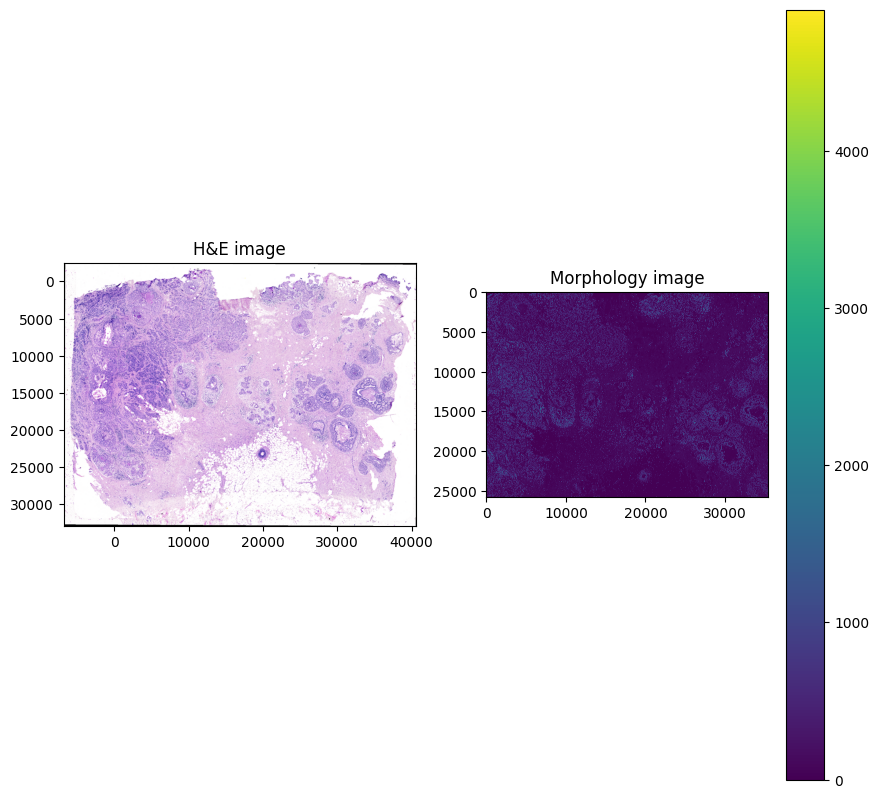

In [11]:
import matplotlib.pyplot as plt
import spatialdata_plot

axes = plt.subplots(1, 2, figsize=(10, 10))[1].flatten()
sdata.pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image")
sdata.pl.render_images("morphology_focus").pl.show(ax=axes[1], title="Morphology image")

## Complete alignment

For these data, even after alignment I had very different coordinate systems... So I needed to transform again my data. The good point is that my slide is well oriented, but I don't know which transformation to perform in order to align my CS. So basically, based on the global crops, I zoomed on 3 zones. I tried to find the exact same 3 zones for both global CS and mine :

In [12]:
# from spatialdata import bounding_box_query

# # sdata.tables["table"].obs["region"] = "nucleus_boundaries"
# # sdata.set_table_annotates_spatialelement("table", region="nucleus_boundaries")

# axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
# crop0 = lambda x: bounding_box_query(
#     x,
#     min_coordinate=[19700, 22900],
#     max_coordinate=[19900, 23000],
#     axes=("x", "y"),
#     target_coordinate_system="global",
# )
# crop1 = lambda x: bounding_box_query(
#     x,
#     min_coordinate=[16150, 27450],
#     max_coordinate=[16350, 27550],
#     axes=("x", "y"),
#     target_coordinate_system="Xenium_he",
# )

# crop0(sdata).pl.render_shapes("nucleus_boundaries", color="cell_id",).pl.show(ax=axes[0], title="Nucleus Boundaries", coordinate_systems="global")
# crop1(sdata).pl.render_shapes("nucleus_boundaries_hn", color="cell_id",).pl.show(ax=axes[1], title="Nucleus Boundaries HoverNet", coordinate_systems="Xenium_he")

In [13]:
# from spatialdata import bounding_box_query

# # sdata.tables["table"].obs["region"] = "nucleus_boundaries"
# # sdata.set_table_annotates_spatialelement("table", region="nucleus_boundaries")

# axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
# crop2 = lambda x: bounding_box_query(
#     x,
#     min_coordinate=[13520, 14480],
#     max_coordinate=[13590, 14580],
#     axes=("x", "y"),
#     target_coordinate_system="global",
# )
# crop3 = lambda x: bounding_box_query(
#     x,
#     min_coordinate=[9950, 19050],
#     max_coordinate=[10050, 19130],
#     axes=("x", "y"),
#     target_coordinate_system="Xenium_he",
# )

# crop2(sdata).pl.render_shapes("nucleus_boundaries", color="cell_id",).pl.show(ax=axes[0], title="Nucleus Boundaries", coordinate_systems="global")
# crop3(sdata).pl.render_shapes("nucleus_boundaries_hn", color="cell_id",).pl.show(ax=axes[1], title="Nucleus Boundaries HoverNet", coordinate_systems="Xenium_he")

In [14]:
# axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
# crop4 = lambda x: bounding_box_query(
#     x,
#     min_coordinate=[29250, 15800],
#     max_coordinate=[29400, 16000],
#     axes=("x", "y"),
#     target_coordinate_system="global",
# )
# crop5 = lambda x: bounding_box_query(
#     x,
#     min_coordinate=[25670, 20350],
#     max_coordinate=[25900, 20550],
#     axes=("x", "y"),
#     target_coordinate_system="Xenium_he",
# )

# crop4(sdata).pl.render_shapes("nucleus_boundaries", color="cell_id",).pl.show(ax=axes[0], title="Nucleus Boundaries", coordinate_systems="global")
# crop5(sdata).pl.render_shapes("nucleus_boundaries_hn", color="cell_id",).pl.show(ax=axes[1], title="Nucleus Boundaries HoverNet", coordinate_systems="Xenium_he")

Then I fixed a specific point in each zoom, and I reported the coordinates of the points both in the global CS and in my own CS :

In [15]:
# from spatialdata.models import ShapesModel
# from spatialdata.transformations import Identity
# import numpy as np

# xenium_he_landmarks = ShapesModel.parse(
#     np.array([[9974, 19030], [16150, 27550], [25675, 20502]]),
#     geometry=0,
#     radius=500,
#     transformations={"Xenium_he": Identity()},
# )
# sdata["xenium_he_landmarks"] = xenium_he_landmarks

# # for Xenium data, the data is aligned to the 'global' coordinate system as with can see with print(xenium_sdata), so there is no need to specify transformations in .parse()
# sdata_landmarks = ShapesModel.parse(
#     np.array([[13540, 14480], [19713, 23000], [29238, 15950]]), geometry=0, radius=500
# )
# sdata["sdata_landmarks"] = sdata_landmarks

The following code enables us to align two CS based on some landmarks :

In [16]:
# from spatialdata.transformations import (
#     align_elements_using_landmarks,
#     get_transformation_between_landmarks,
# )

# affine = get_transformation_between_landmarks(
#     references_coords=sdata["sdata_landmarks"], moving_coords=sdata["xenium_he_landmarks"]
# )
# affine

Finally, I needed to combine the two affine transformations (the one I found on 10x Genomics website and the 'last one') to get the global affine matrix for alignment :

In [17]:
# T_combined = affine.matrix @ image_transform.matrix
# np.savetxt(PATH_DATA + "/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment_new.csv", T_combined, delimiter=",")

## Other visualizations

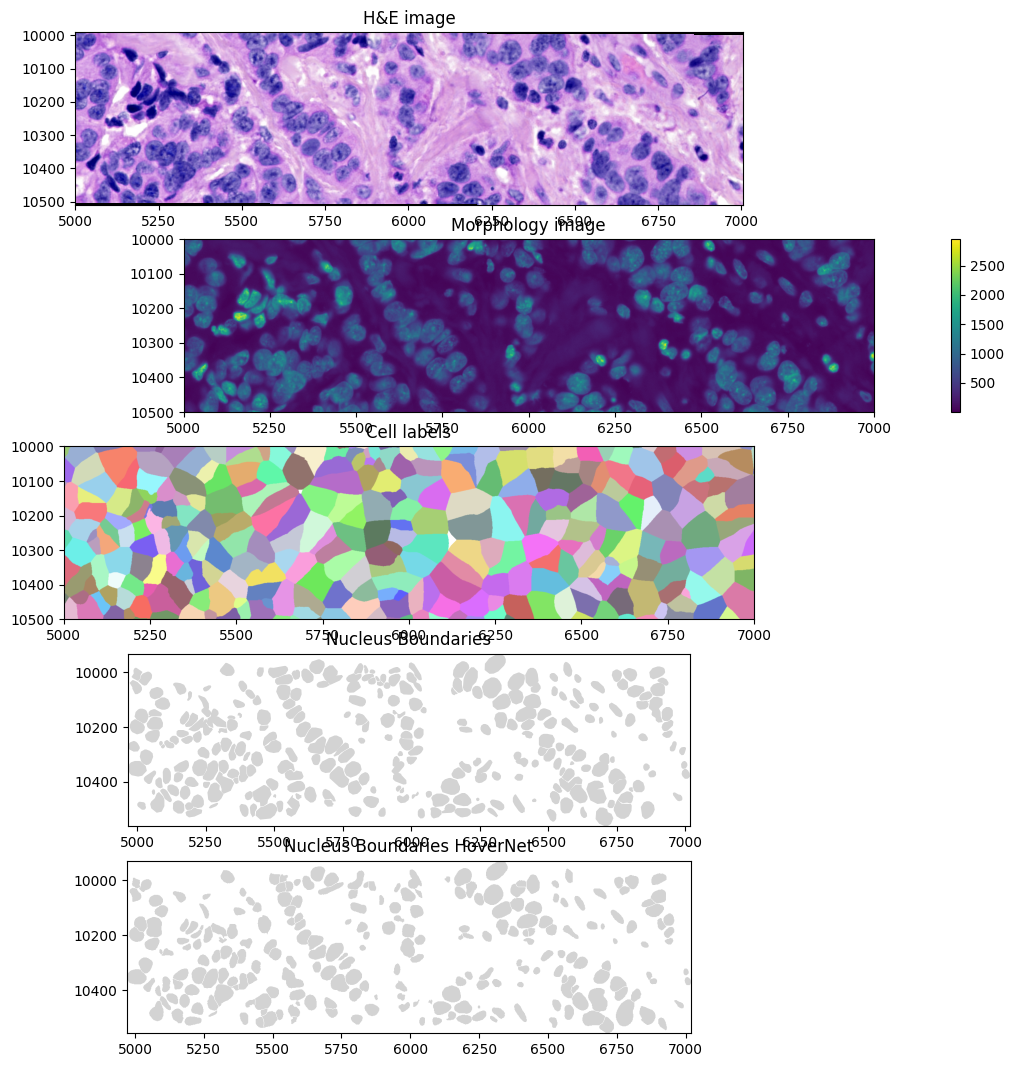

In [12]:
from spatialdata import bounding_box_query

axes = plt.subplots(5, 1, figsize=(20, 13))[1].flatten()
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[5_000, 10000],
    max_coordinate=[7_000, 10500],
    axes=("x", "y"),
    target_coordinate_system="global",
)
crop0(sdata).pl.render_images("he_image").pl.show(ax=axes[0], title="H&E image", coordinate_systems="global")
crop0(sdata).pl.render_images("morphology_focus").pl.show(
    ax=axes[1], title="Morphology image", coordinate_systems="global"
)
crop0(sdata).pl.render_labels("cell_labels").pl.show(ax=axes[2], title="Cell labels", coordinate_systems="global")
crop0(sdata).pl.render_shapes("nucleus_boundaries").pl.show(ax=axes[3], title="Nucleus Boundaries", coordinate_systems="global")
crop0(sdata).pl.render_shapes("nucleus_boundaries_hn").pl.show(ax=axes[4], title="Nucleus Boundaries HoverNet", coordinate_systems="global")

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


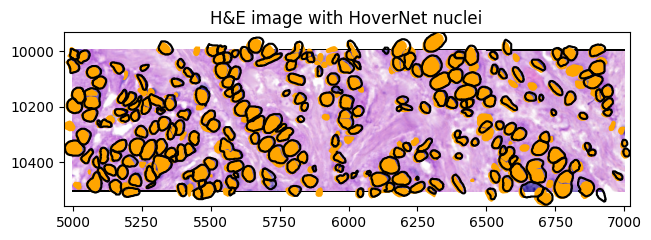

In [13]:
crop0(sdata).pl.render_images(
    "he_image",
    ).pl.render_shapes(
        "nucleus_boundaries",
        color="orange",
    ).pl.render_shapes(
        "nucleus_boundaries_hn",
        fill_alpha=0,
        outline_alpha=1,
        outline_color="black",
    ).pl.show(title="H&E image with HoverNet nuclei", coordinate_systems="global")

# Data pre-processing

## Prepare Xenium data

In [109]:
new_index_name = "gene_ids"
sdata.tables["table"].var["SYMBOL"] = sdata.tables["table"].var_names
sdata.tables["table"].var.set_index(new_index_name, drop=True, inplace=True)
print("-->Variables made unique.")

-->Variables made unique.


In [110]:
import numpy as np

threshold = 10
xenium_cm = np.array(sdata.tables["table"].X.todense())
xenium_cm_mask = xenium_cm.sum(1) > threshold
xenium_adata_filtered = sdata.tables["table"][xenium_cm_mask].copy()

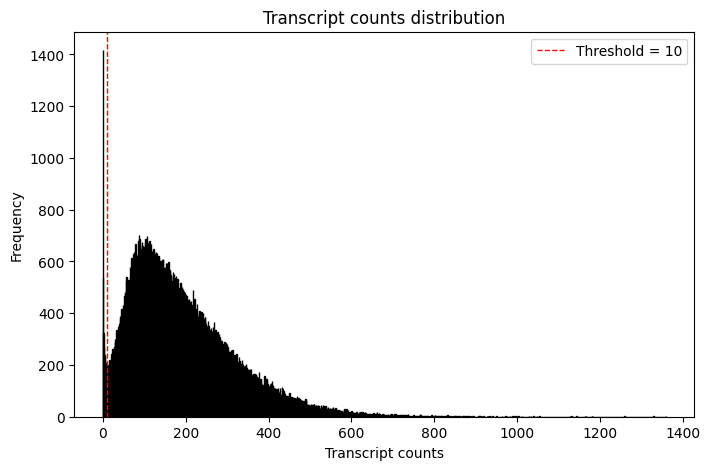

In [ ]:
threshold = 10
transcript_counts = xenium_cm.sum(1)
bins = np.arange(transcript_counts.min(), transcript_counts.max() + 2) - 0.5
plt.figure(figsize=(8, 5))
plt.hist(transcript_counts, bins=bins, edgecolor='black')
plt.axvline(x=threshold, color='red', linestyle='--', linewidth=1, label=f"Threshold = {threshold}") 
plt.xlabel("Transcript counts")
plt.ylabel("Frequency")
plt.title("Transcript counts distribution")
plt.legend()
# plt.savefig("fig/breast/transcript_counts_distribution.png", dpi=500)
plt.show()

In [14]:
import scanpy as sc

sc.tl.pca(xenium_adata_filtered)
sc.pp.neighbors(xenium_adata_filtered, use_rep="X_pca")
sc.tl.umap(xenium_adata_filtered)
sc.tl.louvain(xenium_adata_filtered, resolution=0.5)

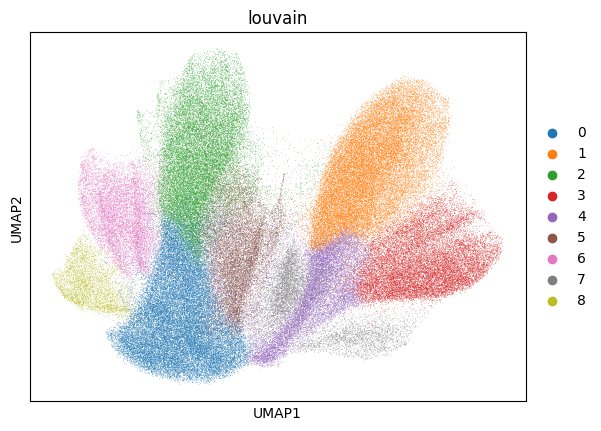

In [17]:
sc.pl.umap(xenium_adata_filtered, color="louvain", wspace=0.35)

# Annotation

In [111]:
import pandas as pd

annotations = pd.read_excel(PATH_DATA+'/Cell_Barcode_Type_Matrices.xlsx', sheet_name='Xenium R1 Fig1-5 (supervised)')

# cells = sdata["cell_boundaries"]
# cell_annotations = pd.merge(cells, annotations, how='left', left_on=['cell_id'], right_on=['Barcode']).dropna()

In [112]:
cell_type_mapping = {
    'CD4+_T_Cells': 'T_Cells',
    'CD8+_T_Cells': 'T_Cells',
    'T_Cell_&_Tumor_Hybrid': 'T_Cells',
    'Macrophages_1': 'Macrophages',
    'Macrophages_2': 'Macrophages',
    'IRF7+_DCs': 'Dendritic_Cells',
    'LAMP3+_DCs': 'Dendritic_Cells',
    'Myoepi_ACTA2+': 'Myoepithelial_Cells',
    'Myoepi_KRT15+': 'Myoepithelial_Cells',
    'Invasive_Tumor': 'Tumor_Cells',
    'Prolif_Invasive_Tumor': 'Tumor_Cells',
    'DCIS_1': 'Tumor_Cells',
    'DCIS_2': 'Tumor_Cells',
    'Stromal': 'Stromal_Cells',
    'Stromal_&_T_Cell_Hybrid': 'Stromal_Cells',
    'Endothelial': 'Endothelial_Cells',
    'B_Cells': 'B_Cells',
    'Perivascular-Like': 'Perivascular_Cells',
    'Mast_Cells': 'Mast_Cells',
    'Unlabeled': 'Unlabeled'
}

color_dict = {
    '0': ['Tumor_Cells', [31, 119, 180, 255]],
    '1': ['Macrophages', [0, 170, 140, 255]],
    '2': ['Stromal_Cells', [255, 140, 0, 255]],
    '3': ['Myoepithelial_Cells', [255, 220, 100, 255]],
    '4': ['T_Cells', [0, 150, 0, 255]],
    '5': ['Endothelial_Cells', [230, 90, 60, 255]],
    '6': ['B_Cells', [200, 255, 200, 255]]
}

In [ ]:
# cell_type_mapping = {
#     'CD4+_T_Cells': 'inflam',
#     'CD8+_T_Cells': 'inflam',
#     'T_Cell_&_Tumor_Hybrid': 'Unlabeled',  # hybrid, could include tumor and immune
#     'Macrophages_1': 'inflam',
#     'Macrophages_2': 'inflam',
#     'IRF7+_DCs': 'inflam',
#     'LAMP3+_DCs': 'inflam',
#     'Myoepi_ACTA2+': 'connec',
#     'Myoepi_KRT15+': 'connec',
#     'Invasive_Tumor': 'neopla',
#     'Prolif_Invasive_Tumor': 'neopla',
#     'DCIS_1': 'neopla',
#     'DCIS_2': 'neopla',
#     'Stromal': 'connec',
#     'Stromal_&_T_Cell_Hybrid': 'Unlabeled',  # mixed stroma and immune
#     'Endothelial': 'connec',
#     'B_Cells': 'inflam',
#     'Perivascular-Like': 'connec',
#     'Mast_Cells': 'inflam',
#     'Unlabeled': 'Unlabeled'
# }

# color_dict = {
#     '0': ['neopla', [31, 119, 180, 255]],
#     '1': ['inflam', [0, 170, 140, 255]],
#     '2': ['connec', [255, 140, 0, 255]]
# }

In [113]:
annotations['cell_type'] = annotations['Cluster'].map(cell_type_mapping).fillna(annotations['Cluster'])
group_counts = annotations['cell_type'].value_counts()
low_count_groups = group_counts[group_counts < 1000].index
annotations['cell_type'] = annotations['cell_type'].apply(lambda x: 'Unlabeled' if x in low_count_groups else x)
sdata.tables["table"].obs["cell_type"] = annotations["cell_type"].values
sdata.tables["table"].obs["cell_type"].value_counts()

cell_type
Tumor_Cells            62755
Stromal_Cells          42029
T_Cells                15982
Macrophages            12798
Unlabeled              10360
Myoepithelial_Cells     9938
Endothelial_Cells       8931
B_Cells                 4987
Name: count, dtype: int64

In [114]:
ct_list = sdata.tables["table"].obs["cell_type"].unique().tolist()
if "Unlabeled" in ct_list:
    ct_list.remove("Unlabeled")
    ct_list.append("Unlabeled")
ct_list_without_unlabeled = [ct for ct in ct_list if ct != "Unlabeled"]

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata/_core/spatialdata.py:480: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/basic.py:879: UserWarning: Converting copy of 'cell_type' column to categorical dtype for categorical plotting. Consider converting before plotting.
  _render_shapes(
/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


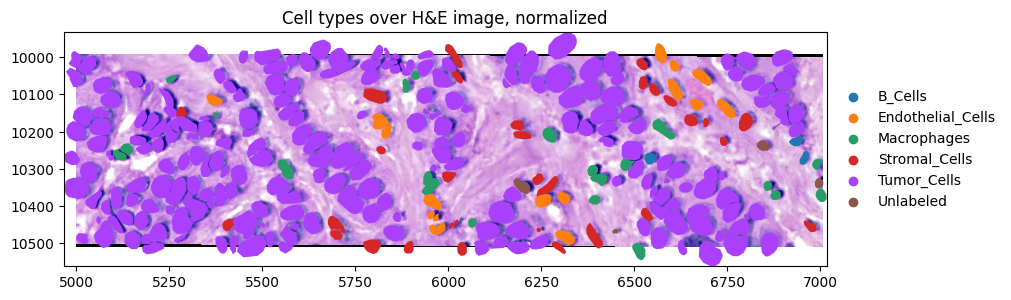

In [23]:
sdata.tables["table"].obs["region"] = "nucleus_boundaries"
sdata.set_table_annotates_spatialelement("table", region="nucleus_boundaries")

crop0(sdata).pl.render_images("he_image").pl.render_shapes(
    "nucleus_boundaries",
    color="cell_type",
).pl.show(title=f"Cell types over H&E image, normalized", coordinate_systems="global", figsize=(10, 5))

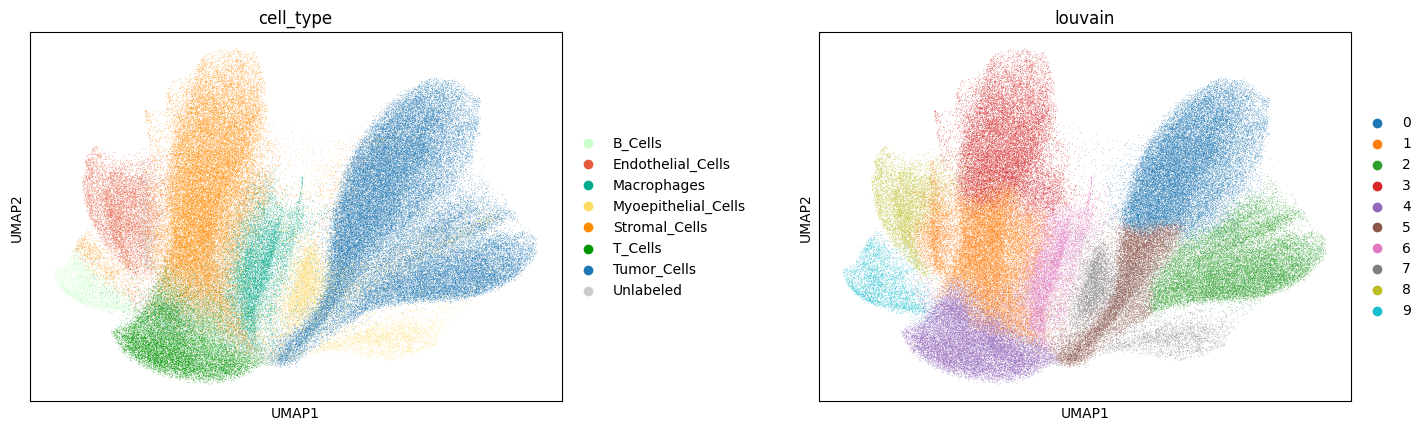

In [84]:
import matplotlib.colors as mcolors

cell_type_colors = {
    v[0]: mcolors.to_hex(np.array(v[1][:3]) / 255)
    for v in color_dict.values()
}

xenium_adata_filtered.obs["cell_type"] = xenium_adata_filtered.obs["cell_type"].astype("category")
cell_type_order = xenium_adata_filtered.obs["cell_type"].cat.categories
xenium_adata_filtered.uns["cell_type_colors"] = [
    cell_type_colors.get(ct,"#cccccc")  # fallback gray for missing types
    for ct in cell_type_order
]

annotated_xenium_adata = sdata.tables["table"].copy()
xenium_adata_filtered.obs["cell_type"] = annotated_xenium_adata.obs["cell_type"][xenium_cm_mask].values
sc.pl.umap(xenium_adata_filtered, color=["cell_type", "louvain"], wspace=0.35, save='Xenium_Human_Breast_Cancer_annotated_umap.png')

# Nucleus Matching

In [115]:
gdf_nucleus_hn = sdata.shapes["nucleus_boundaries_hn"]
gdf_nucleus = sdata.shapes["nucleus_boundaries"]

In [116]:
import utils

affine_matrix = get_transformation(gdf_nucleus_hn).matrix
scale_list = get_transformation(gdf_nucleus).__dict__["scale"].tolist()
scale_x, scale_y = scale_list

shapely_affine = (
    affine_matrix[0, 0],  # a
    affine_matrix[0, 1],  # b
    affine_matrix[1, 0],  # d
    affine_matrix[1, 1],  # e
    affine_matrix[0, 2],  # xoff
    affine_matrix[1, 2]   # yoff
)

shapely_affine2 = (
    scale_x,  # a
    0,  # b
    0,  # d
    scale_y,  # e
    0,  # xoff
    0   # yoff
)

gdf_nucleus_hn_transformed = gdf_nucleus_hn.copy()
gdf_nucleus_transformed = gdf_nucleus.copy()

gdf_nucleus_hn_transformed.geometry = utils.apply_transformation_to_gdf(gdf_nucleus_hn_transformed, shapely_affine)
gdf_nucleus_transformed.geometry = utils.apply_transformation_to_gdf(gdf_nucleus_transformed, shapely_affine2)

In [117]:
nucleus_to_nucleus = utils.find_closest_nucleus(gdf_nucleus_transformed, gdf_nucleus_hn_transformed)

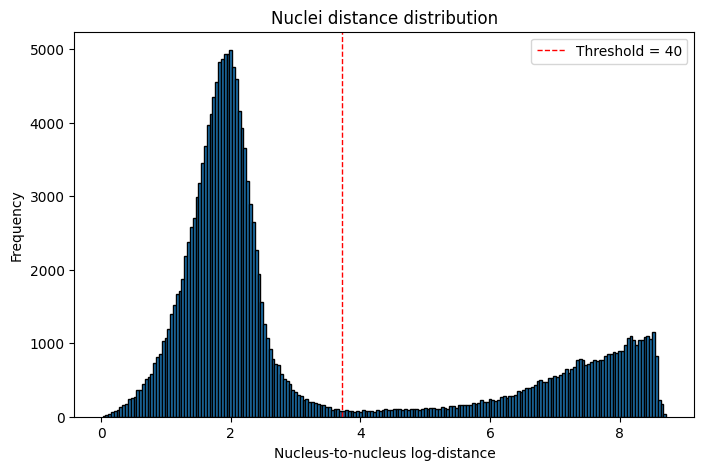

In [ ]:
import numpy as np

threshold = 40
bins = 200
log_distances = np.log(nucleus_to_nucleus["distance"]+1)
plt.figure(figsize=(8, 5))
plt.hist(log_distances, bins=bins, edgecolor='black')
plt.axvline(x=np.log(threshold+1), color='red', linestyle='--', linewidth=1, label=f"Threshold = {threshold}") 
plt.xlabel("Nucleus-to-nucleus log-distance")
plt.ylabel("Frequency")
plt.title("Nuclei distance distribution")
plt.legend()
# plt.savefig("fig/breast/nuclei_distance_distribution.png", dpi=500)
plt.show()

In [118]:
nucleus_to_nucleus["nucleus_hn_id"] = nucleus_to_nucleus.index.astype(str)
nucleus_to_nucleus = nucleus_to_nucleus[nucleus_to_nucleus['distance'] < threshold]
nucleus_to_nucleus = nucleus_to_nucleus.rename(columns={"nucleus_id": "cell_id"})
nucleus_to_nucleus = nucleus_to_nucleus.loc[nucleus_to_nucleus.groupby('cell_id')['distance'].idxmin()]
nucleus_to_nucleus

cell_id  distance nucleus_hn_id
167281        1  1.313919        167281
167273        2  7.799099        167273
167275        5  4.976332        167275
140107        8  1.480121        140107
140104       10  6.214964        140104
...         ...       ...           ...
149324   167775  3.278374        149324
117507   167776  3.926367        117507
149320   167778  4.038667        149320
149318   167779  0.666994        149318
149319   167780  3.587248        149319

[114309 rows x 3 columns]

In [119]:
nucleus_to_nucleus = nucleus_to_nucleus.merge(sdata.tables["table"].obs.copy(), on='cell_id', how='left')
nucleus_to_nucleus['cell_type_id'] = nucleus_to_nucleus['cell_type'].map({cell: rank for rank, cell in enumerate(ct_list)})
nucleus_to_nucleus = nucleus_to_nucleus.reindex(columns=["cell_id", "nucleus_hn_id", "distance", "cell_type", "cell_type_id"])
nucleus_to_nucleus = nucleus_to_nucleus.rename(columns={"nucleus_hn_id": "nucleus_id"})
nucleus_to_nucleus

cell_id nucleus_id  distance    cell_type  cell_type_id
0             1     167281  1.313919  Tumor_Cells             0
1             2     167273  7.799099  Tumor_Cells             0
2             5     167275  4.976332  Tumor_Cells             0
3             8     140107  1.480121  Tumor_Cells             0
4            10     140104  6.214964  Macrophages             1
...         ...        ...       ...          ...           ...
114304   167775     149324  3.278374  Tumor_Cells             0
114305   167776     117507  3.926367  Tumor_Cells             0
114306   167778     149320  4.038667  Tumor_Cells             0
114307   167779     149318  0.666994  Tumor_Cells             0
114308   167780     149319  3.587248  Tumor_Cells             0

[114309 rows x 5 columns]

# Simulate Visium spots

## Define the grid

In [120]:
from spatialdata import get_extent

extent = get_extent(sdata)
extent

{'y': (-2460.900801930311, 32888.64217476546),
 'x': (-6829.57585757872, 40577.759304000865),
 'z': (2.4367334842681885, 50.03297424316406)}

<Axes: >

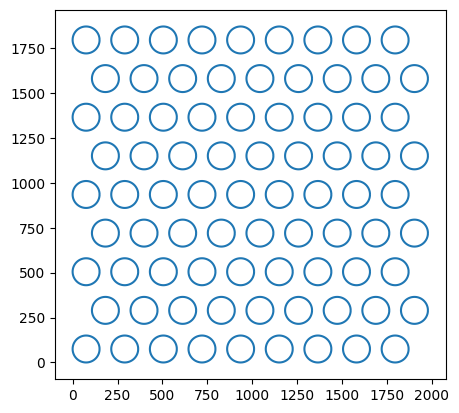

In [33]:
example = utils.make_spot_grid(
    x_min=0,
    x_max=2000,
    y_min=0,
    y_max=2000,
    diameter=150,
    spacing=215)
example.boundary.plot() #350, 500

In [121]:
spot_orga = "real"
if spot_orga == "real":
    diameter, spacing = 350, 500
else:
    diameter, spacing = 150, 215

gdf_spots = utils.make_spot_grid(
    x_min=extent["x"][0].item(),
    x_max=extent["x"][1].item(),
    y_min=extent["y"][0].item(),
    y_max=extent["y"][1].item(),
    diameter=diameter,
    spacing=spacing
)

sdata.shapes["pseudo_spots"] = gdf_spots

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/basic.py:879: UserWarning: Converting copy of 'cell_type' column to categorical dtype for categorical plotting. Consider converting before plotting.
  _render_shapes(
/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


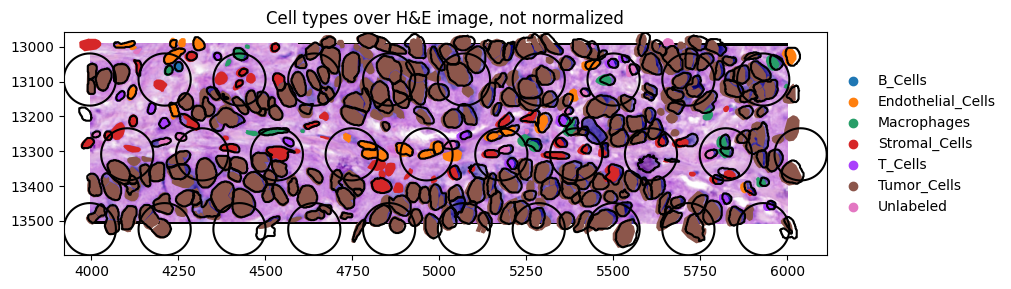

In [32]:
crop1 = lambda x: bounding_box_query(
    x,
    min_coordinate=[4_000, 13000],
    max_coordinate=[6_000, 13500],
    axes=("x", "y"),
    target_coordinate_system="global",
)

crop1(sdata).pl.render_images("he_image").pl.render_shapes(
    "nucleus_boundaries",
    color="cell_type",
).pl.render_shapes(
    "nucleus_boundaries_hn",
    fill_alpha=0,
    outline_alpha=1,
    outline_color="black",
).pl.render_shapes(
    "pseudo_spots",
    fill_alpha=0,
    outline_alpha=1,
    outline_color="black",
).pl.show(title=f"Cell types over H&E image, not normalized", coordinate_systems="global", figsize=(10, 5))

## Match nuclei and spots

In [122]:
gdf_nucleus = sdata.shapes["nucleus_boundaries_hn"]
nuclei_in_spots = utils.match_nuclei_in_spots(gdf_spots, gdf_nucleus)
nuclei_in_spots

nucleus_id spot_id
0              0    6250
1              1    6250
2              7    6155
3              9    6155
4             11    6155
...          ...     ...
67317     175163    3391
67318     175164    3392
67319     175168    3392
67320     175171    3391
67321     175174    3392

[67322 rows x 2 columns]

In [123]:
pseudo_data = nucleus_to_nucleus[nucleus_to_nucleus["nucleus_id"].isin(nuclei_in_spots["nucleus_id"])]
pseudo_data = pseudo_data.merge(nuclei_in_spots[["nucleus_id", "spot_id"]], on="nucleus_id", how="left")
pseudo_data = pseudo_data.reindex(columns=["nucleus_id", "cell_id", "spot_id", "cell_type", "cell_type_id"])
pseudo_data

nucleus_id  cell_id spot_id            cell_type  cell_type_id
0         167273        2     777          Tumor_Cells             0
1         140107        8     777          Tumor_Cells             0
2         140104       10     777          Macrophages             1
3         140098       12     777            Unlabeled             7
4         140091       22     777          Tumor_Cells             0
...          ...      ...     ...                  ...           ...
43781     149285   167757    5187          Tumor_Cells             0
43782     149280   167760    5187  Myoepithelial_Cells             3
43783     149271   167767    5187          Tumor_Cells             0
43784     149320   167778    5092          Tumor_Cells             0
43785     149318   167779    5092          Tumor_Cells             0

[43786 rows x 5 columns]

In [124]:
pseudo_data = pseudo_data[pseudo_data["cell_type"] != "Unlabeled"]
if pseudo_data["cell_type"].dtype.name == "category":
    pseudo_data["cell_type"] = pseudo_data["cell_type"].cat.remove_categories(["Unlabeled"])

In [125]:
spot_counts = pseudo_data['spot_id'].value_counts()
valid_spots = spot_counts[spot_counts >= 4].index
pseudo_data = pseudo_data[pseudo_data['spot_id'].isin(valid_spots)]
pseudo_data

nucleus_id  cell_id spot_id            cell_type  cell_type_id
0         167273        2     777          Tumor_Cells             0
1         140107        8     777          Tumor_Cells             0
2         140104       10     777          Macrophages             1
4         140091       22     777          Tumor_Cells             0
6         140450       68     588          Tumor_Cells             0
...          ...      ...     ...                  ...           ...
43781     149285   167757    5187          Tumor_Cells             0
43782     149280   167760    5187  Myoepithelial_Cells             3
43783     149271   167767    5187          Tumor_Cells             0
43784     149320   167778    5092          Tumor_Cells             0
43785     149318   167779    5092          Tumor_Cells             0

[40150 rows x 5 columns]

## Check matching

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata/_core/spatialdata.py:480: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/basic.py:879: UserWarning: Converting copy of 'cell_type' column to categorical dtype for categorical plotting. Consider converting before plotting.
  _render_shapes(
/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


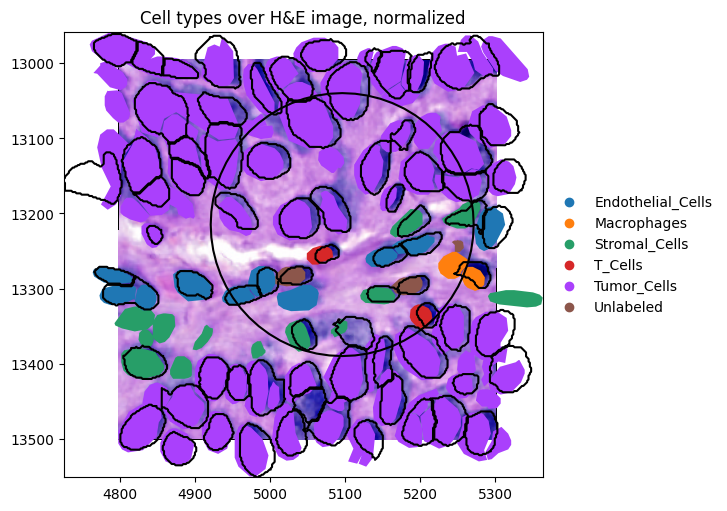

In [57]:
sdata.tables["table"].obs["region"] = "nucleus_boundaries"
sdata.set_table_annotates_spatialelement("table", region="nucleus_boundaries")

crop2 = lambda x: bounding_box_query(
    x,
    min_coordinate=[4800, 13000],
    max_coordinate=[5300, 13500],
    axes=("x", "y"),
    target_coordinate_system="global",
)

crop2(sdata).pl.render_images("he_image").pl.render_shapes(
    "nucleus_boundaries",
    color="cell_type",
).pl.render_shapes(
    "nucleus_boundaries_hn",
    fill_alpha=0,
    outline_alpha=1,
    outline_color="black",
).pl.render_shapes(
    "pseudo_spots",
    fill_alpha=0,
    outline_alpha=1,
    outline_color="black",
).pl.show(title=f"Cell types over H&E image, normalized", coordinate_systems="global", figsize=(10, 5))

In [58]:
spot_index = crop2(sdata)["pseudo_spots"].index.values[0]
inside_spot = pseudo_data[pseudo_data["spot_id"] == spot_index]
inside_spot

nucleus_id  cell_id spot_id          cell_type  cell_type_id
16124      59268    58053    2953        Tumor_Cells             0
16125      59253    58054    2953      Stromal_Cells             2
16126      59250    58055    2953        Tumor_Cells             0
16127      59252    58056    2953        Tumor_Cells             0
16128      59246    58057    2953      Stromal_Cells             2
16129      59245    58058    2953        Tumor_Cells             0
16130      59224    58061    2953  Endothelial_Cells             5
16131      59220    58062    2953            T_Cells             4
16132      59216    58063    2953  Endothelial_Cells             5
16135      59187    58068    2953  Endothelial_Cells             5
16136      59177    58069    2953      Stromal_Cells             2
16137      59175    58070    2953  Endothelial_Cells             5
16138      59157    58072    2953            T_Cells             4
16139      59142    58073    2953      Stromal_Cells             2
16140      59140    58074    2953      Stromal_Cells             2
16458      59335    59204    2953        Tumor_Cells             0
16459      59307    59210    2953        Tumor_Cells             0
16460      59292    59211    2953        Tumor_Cells             0
16461      59293    59213    2953        Tumor_Cells             0
16462      59282    59214    2953        Tumor_Cells             0
16465      59333    59222    2953        Tumor_Cells             0

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/geopandas/geoseries.py:720: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)


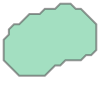

In [59]:
from shapely.affinity import rotate, scale

nucleus_id = 59220	
nucleus_shape = sdata["nucleus_boundaries_hn"][sdata["nucleus_boundaries_hn"].index == str(nucleus_id)]
nucleus_shape_copy = nucleus_shape.copy()
nucleus_shape_copy["geometry"][0]

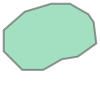

In [60]:
cell_id = 58062	
nucleus_shape = sdata["nucleus_boundaries"][sdata["nucleus_boundaries"].index == cell_id]
nucleus_shape_copy = nucleus_shape.copy()
nucleus_shape_copy = nucleus_shape_copy["geometry"].apply(lambda geom: scale(geom, xfact=1, yfact=-1, origin="center"))
nucleus_shape_copy.values[0]

## Analyze pseudo data

In [126]:
len(pseudo_data), len(pseudo_data["spot_id"].unique())

(40150, 2589)

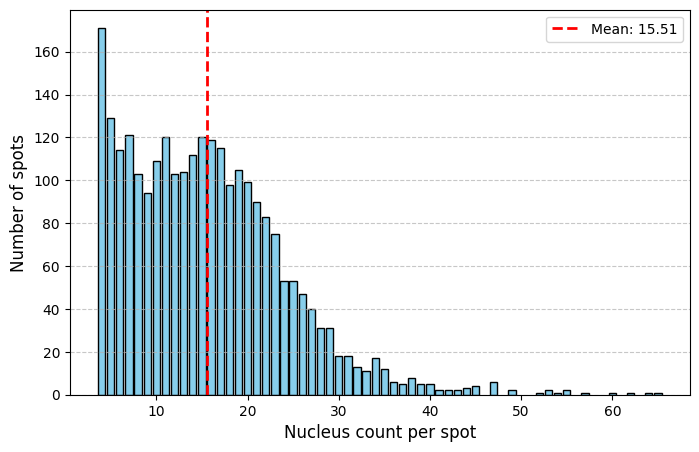

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
utils.histogram_per_spot(pseudo_data,
                         ax=ax,
                         title = "",
                         show_mean=True)
# plt.savefig("fig/breast/nucleus_counts_per_spot.png", dpi=500)

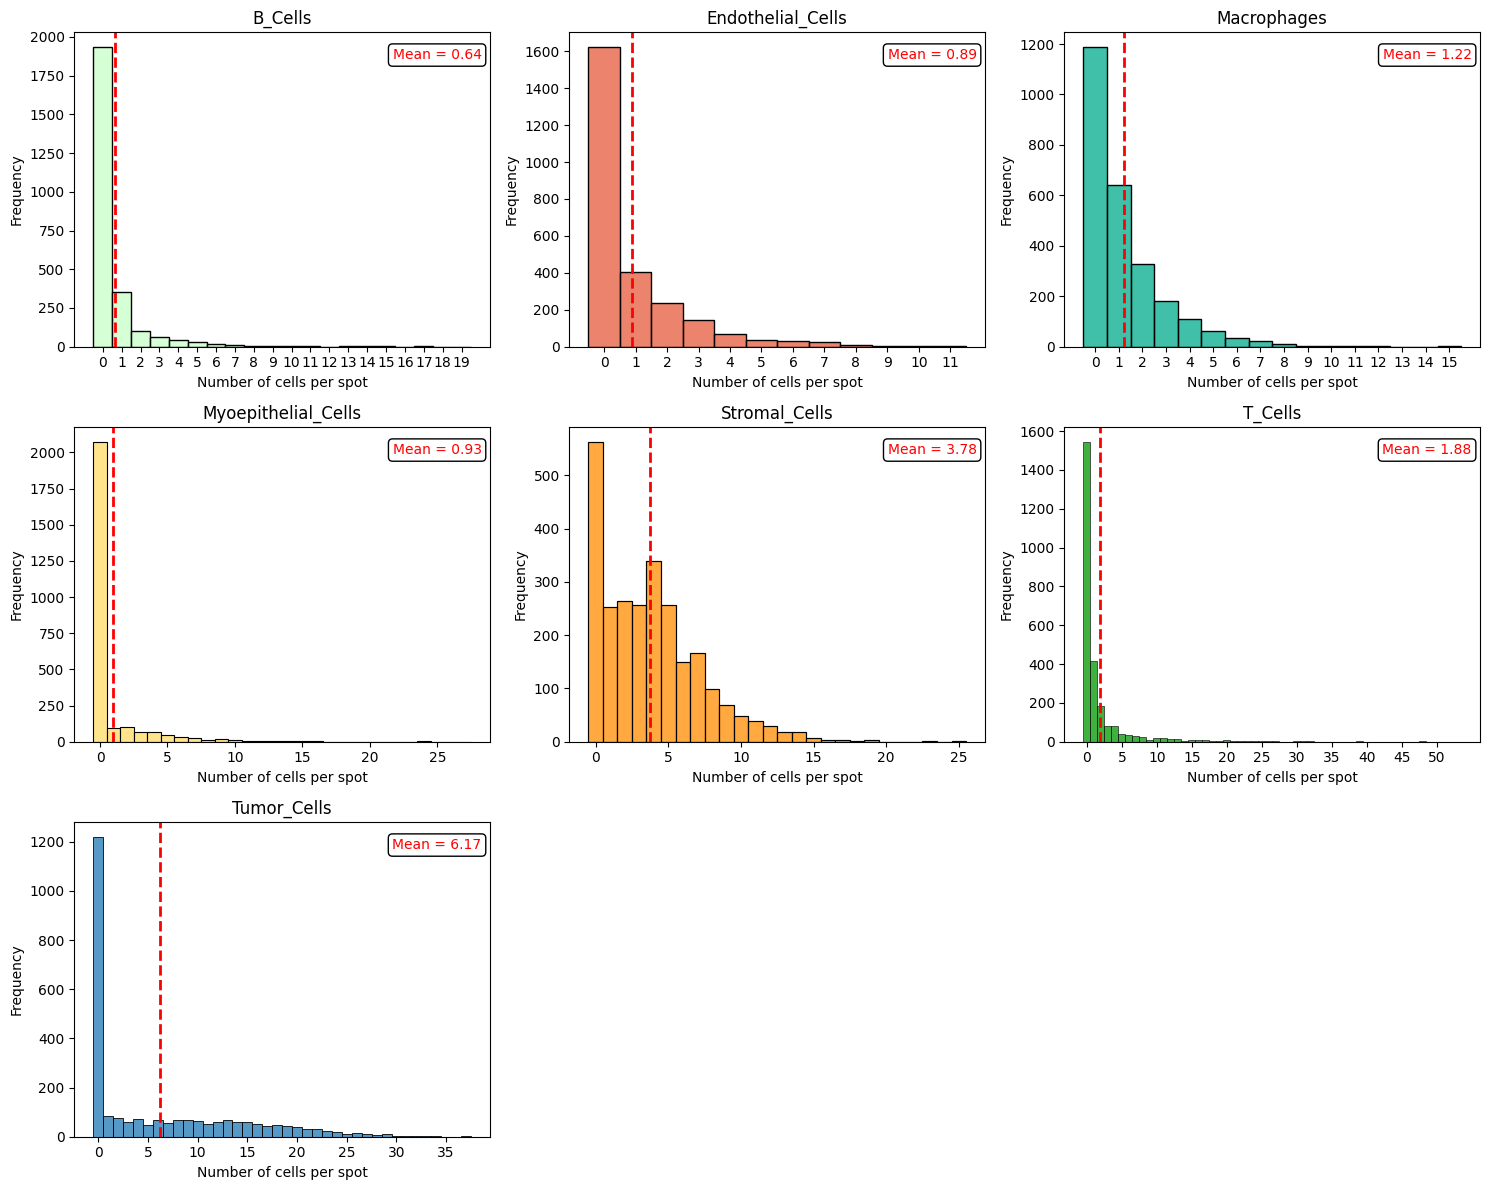

In [ ]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Compute counts of cells per (spot_id, cell_type)
counts = (
    pseudo_data.groupby(["spot_id", "cell_type"])
    .size()
    .unstack(fill_value=0)  # rows = spots, cols = cell types
)

cell_types = counts.columns
n_types = len(cell_types)

n_cols = math.ceil(math.sqrt(n_types))
n_rows = math.ceil(n_types / n_cols)

color_map = {
    v[0]: tuple(np.array(v[1][:3]) / 255)
    for v in color_dict.values()
}

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
# fig, axes = plt.subplots(1, 3, figsize=(3 * 5, 1 * 4))
axes = axes.flatten()

# Cell types for which we only want sparse x-ticks
sparse_xtick_types = ["Myoepithelial_Cells", "Stromal_Cells", "T_Cells", "Tumor_Cells", "inflam", "connec", "neopla"]

for idx, cell_type in enumerate(cell_types):
    ax = axes[idx]
    data = counts[cell_type]
    mean_val = data.mean()

    # Define integer bins (one per cell count)
    max_val = int(data.max())
    bins = np.arange(-0.5, max_val + 1.5, 1)

    # Plot histogram
    color = color_map.get(cell_type)
    sns.histplot(data, bins=bins, ax=ax, color=color, edgecolor="black")

    # Vertical line for the mean
    ax.axvline(mean_val, color="red", linestyle="--", linewidth=2)

    # Mean value box in top-right corner
    ax.text(
        0.98, 0.95, f"Mean = {mean_val:.2f}",
        transform=ax.transAxes,
        ha="right", va="top",
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
        fontsize=10, color="red"
    )

    ax.set_title(cell_type)
    ax.set_xlabel("Number of cells per spot")
    ax.set_ylabel("Frequency")

    # X-axis ticks: all integers, but sparse for some cell types
    if cell_type in sparse_xtick_types:
        step = 5
        ax.set_xticks(np.arange(0, max_val + 1, step))
    else:
        ax.set_xticks(range(max_val + 1))

# Turn off any extra subplots
for ax in axes[len(cell_types):]:
    ax.axis("off")

plt.tight_layout()
# plt.savefig("fig/breast/cell_type_distribution_per_spot_7_types.png", dpi=500)
plt.show()

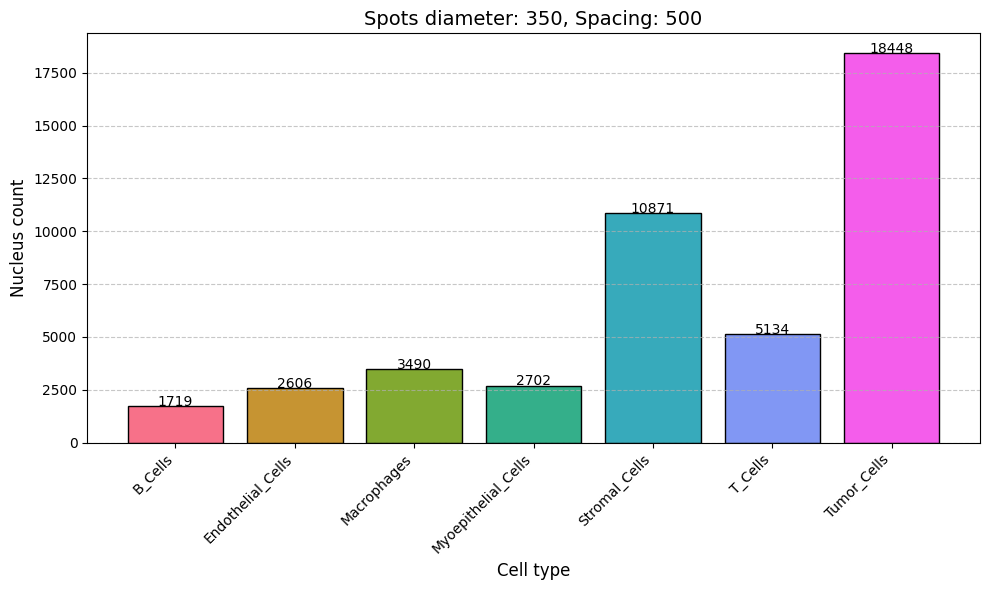

In [42]:
nucleus_per_cell_type = pseudo_data.groupby("cell_type").size()

plt.figure(figsize=(10, 6))
bars = plt.bar(
    nucleus_per_cell_type.index, 
    nucleus_per_cell_type.values, 
    color=palette,
    edgecolor="black"
)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.5,
        str(height),
        ha="center",
        fontsize=10
    )

plt.xlabel("Cell type", fontsize=12)
plt.ylabel("Nucleus count", fontsize=12)
plt.title(f"Spots diameter: {diameter}, Spacing: {spacing}", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

# Save pseudo data

## AnnData with spot coordinates

In [42]:
transformation = get_transformation(sdata["nucleus_boundaries_hn"])
inverse_transformation = transformation.inverse() 

inverse_affine_matrix = (
    inverse_transformation.matrix[0, 0],  # a
    inverse_transformation.matrix[0, 1],  # b
    inverse_transformation.matrix[1, 0],  # d
    inverse_transformation.matrix[1, 1],  # e
    inverse_transformation.matrix[0, 2],  # xoff
    inverse_transformation.matrix[1, 2]   # yoff
)

transformed_geometries = utils.apply_transformation_to_gdf(gdf_spots, inverse_affine_matrix)
transformed_geometries.total_bounds

array([  -98.61434038,   159.62891338, 27649.3105201 , 20643.64344046])

In [43]:
spots_df = utils.spot_gdf_to_df(transformed_geometries)
spots_df = spots_df[spots_df.index.isin(pseudo_data["spot_id"])]

In [44]:
from anndata import AnnData

pseudo_adata = AnnData()
pseudo_adata.obs.index = spots_df.index
pseudo_adata.obs["spot_id"] = spots_df.index
pseudo_adata.obsm["spatial"]=spots_df[["x_center", "y_center"]].values.astype(int)
pseudo_adata.uns["spatial"]={"Xenium_FFPE_Human_Breast_Cancer_Rep1":
                             {"scalefactors" : 
                              {"spot_diameter_fullres" : spots_df["diameter"].values[0]}}}

Let's save the pseudo anndata object :

In [45]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/pseudo_adata_{spot_orga}.h5ad"
pseudo_adata.write_h5ad(output_path)

## Spot proportions

In [46]:
cell_counts = pseudo_data.groupby(["spot_id", "cell_type"]).size().reset_index(name="count")
total_counts = cell_counts.groupby("spot_id")["count"].transform("sum")
cell_counts["proportion"] = cell_counts["count"] / total_counts
spot_prop_df = cell_counts.pivot(index="spot_id", columns="cell_type", values="proportion").fillna(0)
spot_prop_df = spot_prop_df.reindex(columns=ct_list_without_unlabeled)
spot_prop_df.index.name = None
spot_prop_df.columns.name = None
spot_prop_df

neopla    inflam    connec
1000  0.047619  0.714286  0.238095
1001  0.000000  0.956522  0.043478
1002  0.000000  0.921053  0.078947
1003  0.000000  0.705882  0.294118
1004  0.214286  0.500000  0.285714
...        ...       ...       ...
991   0.000000  0.250000  0.750000
992   0.000000  0.571429  0.428571
997   0.000000  0.000000  1.000000
998   0.000000  0.944444  0.055556
999   0.000000  0.930233  0.069767

[2650 rows x 3 columns]

Let's save the dataframe with spot proportions :

In [47]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_prop_{spot_orga}.csv"
spot_prop_df.to_csv(output_path, index=True)

## Ground Truth for each nucleus

In [48]:
ground_truth = nucleus_to_nucleus.pivot_table(
    index="nucleus_id",
    columns="cell_type",
    values="cell_id",
    aggfunc=lambda x: 1,
    fill_value=0,
)
ground_truth = ground_truth.reindex(columns=ct_list)
ground_truth.columns.name = None
ground_truth.index = ground_truth.index.astype(int)
ground_truth = ground_truth.sort_index()
ground_truth.index = ground_truth.index.astype(str)
ground_truth = ground_truth[ground_truth["Unlabeled"] != 1].drop(columns=["Unlabeled"])
ground_truth

neopla  inflam  connec
nucleus_id                        
3311             1       0       0
3337             1       0       0
3341             1       0       0
3350             1       0       0
3359             1       0       0
...            ...     ...     ...
175191           0       0       1
175192           0       1       0
175193           0       1       0
175197           0       0       1
175202           0       1       0

[120696 rows x 3 columns]

In [49]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_gt.csv"
ground_truth.to_csv(output_path, index=True)

## HoverNet dictionnary with Xenium annotations

In [50]:
nucleus_ids = list(map(int, hovernet_dict['nuc'].keys()))
id_mapping = {str(old_id): str(new_id) for new_id, old_id in enumerate(nucleus_ids)}
pseudo_dict = hovernet_dict.copy()
pseudo_dict['nuc'] = {id_mapping[k]: v for k, v in hovernet_dict['nuc'].items()}

nucleus_to_type = nucleus_to_nucleus.set_index('nucleus_id')['cell_type_id'].to_dict()

default_type = len(ct_list_without_unlabeled)+1 #max index = cells removed when matching or when removing cell types (max index - 1 = Unlabeled)
for nucleus_id, values in pseudo_dict['nuc'].items():
    values['type'] = nucleus_to_type.get(nucleus_id, default_type)

Let's save the hovernet dictionnary with all the annotations :

In [51]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/pannuke_fast_mask_lvl3_annotated.json"
with open(output_path, 'w') as json_file:
    json.dump(pseudo_dict, json_file)

## Cell to spot dictionnary

### Inside cells

In [53]:
from collections import defaultdict

spot_dict = defaultdict(list)
for spot_id, group in pseudo_data.groupby("spot_id"):
    spot_dict[str(spot_id)] = [str(nucleus_id) for nucleus_id in group["nucleus_id"].tolist()]

In [54]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/spot_dict_{spot_orga}.json"
with open(output_path, "w") as file:
    json.dump(dict(spot_dict), file)

### Spots for bayesian adjustment

In [55]:
gdf_spots_final = gdf_spots[gdf_spots.index.isin(spot_dict.keys())]
nuclei_to_closest_spots = utils.match_nuclei_to_closest_spots(gdf_nucleus, gdf_spots_final)
nuclei_to_closest_spots = nuclei_to_closest_spots[nuclei_to_closest_spots["nucleus_id"].isin(ground_truth.index)]

/home/luca/anaconda3/envs/xenium-env/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


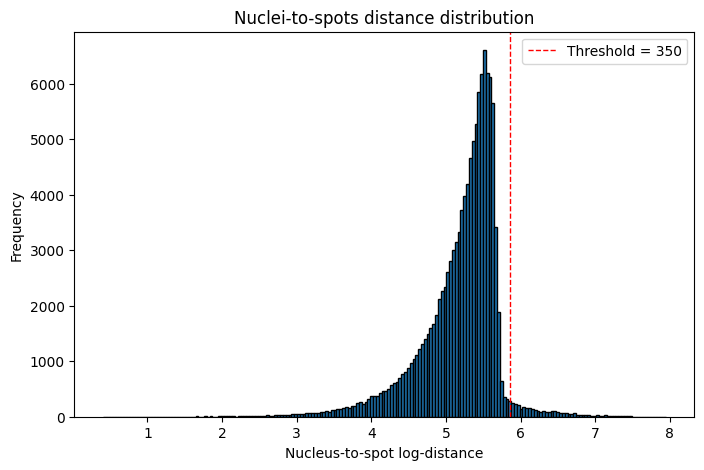

In [56]:
bins = 200
log_distances = np.log(nuclei_to_closest_spots["distance"]+1)
plt.figure(figsize=(8, 5))
plt.hist(log_distances, bins=bins, edgecolor='black')
plt.axvline(x=np.log(diameter+1), color='red', linestyle='--', linewidth=1, label=f"Threshold = {diameter}") 
plt.xlabel("Nucleus-to-spot log-distance")
plt.ylabel("Frequency")
plt.title("Nuclei-to-spots distance distribution")
plt.legend()
plt.show()

In [57]:
nuclei_to_adjust = nuclei_to_closest_spots[nuclei_to_closest_spots["distance"] < diameter]
nuclei_to_adjust

nucleus_id spot_id    distance
3311         3311     581  244.033688
3337         3337     581  303.872570
3341         3341     581  271.013686
9411         9411    3132  232.399286
9656         9656    3132  148.634441
...           ...     ...         ...
175191     175191    3297  272.325052
175192     175192    3391  233.775430
175193     175193    3391  233.029491
175197     175197    3297  249.111001
175202     175202    3296  288.671759

[117500 rows x 3 columns]

In [58]:
spot_dict_adjust = defaultdict(list)
for spot_id, group in nuclei_to_adjust.groupby("spot_id"):
    spot_dict_adjust[str(spot_id)] = [str(nucleus_id) for nucleus_id in group["nucleus_id"].tolist()]

In [59]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/spot_dict_adjust_{spot_orga}.json"
with open(output_path, "w") as file:
    json.dump(dict(spot_dict_adjust), file)

## Filter image_dict

In [60]:
import torch
image_dict = torch.load("/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/image_dict_64.pt")
filtered_image_dict = {k: v for k, v in image_dict.items() if k in ground_truth.index}

/tmp/ipykernel_13351/4023939377.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_dict = torch.load("/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/i

In [61]:
emb_dict = torch.load("/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/moco_embed_moco-XENHBrep1-rn50.pt")
filtered_emb_dict = {k: v for k, v in emb_dict.items() if k in ground_truth.index}

/tmp/ipykernel_13351/82271714.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_dict = torch.load("/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/moco_

In [62]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/image_dict_64.pt"
torch.save(filtered_image_dict, output_path)

In [63]:
output_path = f"/home/luca/Documents/data/Xenium_FFPE_Human_Breast_Cancer_Rep1/sim_hn/moco_embed_moco-XENHBrep1-rn50.pt"
torch.save(filtered_emb_dict, output_path)

# Check data

In [64]:
len(ground_truth)

120696

In [65]:
pseudo_data["cell_type_id"].value_counts()

cell_type_id
0    18448
2    16229
1    10422
Name: count, dtype: int64

In [66]:
ground_truth

neopla  inflam  connec
nucleus_id                        
3311             1       0       0
3337             1       0       0
3341             1       0       0
3350             1       0       0
3359             1       0       0
...            ...     ...     ...
175191           0       0       1
175192           0       1       0
175193           0       1       0
175197           0       0       1
175202           0       1       0

[120696 rows x 3 columns]

In [67]:
list(filtered_image_dict.keys()) == list(ground_truth.index)

True

In [68]:
list(ground_truth.index)

['3311',
 '3337',
 '3341',
 '3350',
 '3359',
 '9411',
 '9656',
 '9709',
 '9803',
 '9904',
 '9929',
 '10123',
 '10137',
 '10159',
 '10224',
 '10270',
 '10297',
 '10336',
 '10380',
 '10403',
 '10415',
 '10482',
 '10498',
 '10511',
 '10518',
 '10549',
 '10585',
 '10642',
 '10661',
 '10694',
 '10786',
 '10871',
 '10894',
 '10954',
 '10979',
 '11116',
 '11117',
 '11118',
 '11119',
 '11120',
 '11121',
 '11122',
 '11123',
 '11124',
 '11125',
 '11126',
 '11127',
 '11128',
 '11129',
 '11130',
 '11131',
 '11132',
 '11133',
 '11134',
 '11135',
 '11136',
 '11138',
 '11139',
 '11140',
 '11141',
 '11142',
 '11143',
 '11144',
 '11145',
 '11146',
 '11147',
 '11149',
 '11150',
 '11151',
 '11152',
 '11153',
 '11154',
 '11155',
 '11156',
 '11157',
 '11158',
 '11159',
 '11160',
 '11161',
 '11162',
 '11163',
 '11164',
 '11166',
 '11167',
 '11168',
 '11169',
 '11170',
 '11171',
 '11172',
 '11173',
 '11174',
 '11175',
 '11176',
 '11177',
 '11178',
 '11179',
 '11180',
 '11181',
 '11182',
 '11183',
 '11184',
 

In [70]:
low_counts_index = []
for cell_id, cell_info in pseudo_dict["nuc"].items():
    if str(cell_info["type"]) == '4':
        low_counts_index.append(cell_id) 
low_counts_index

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138'

In [71]:
len(pseudo_dict["nuc"])

175204

In [72]:
len(spot_dict_adjust)

2650

In [73]:
sum = 0
for list_cells in spot_dict.values():
    sum += len(list_cells)
sum

45099

In [74]:
len(pseudo_data)

45099

# Check Gene Information

In [29]:
from mygene import MyGeneInfo

mg = MyGeneInfo()
mg.getgene(3, fields='name,symbol,refseq')

Input sequence provided is already in string format. No operation performed


{'_id': '3',
 '_version': 1,
 'name': 'alpha-2-macroglobulin pseudogene 1',
 'refseq': {'genomic': ['NC_000012.12', 'NC_060936.1', 'NG_001067.2'],
  'rna': 'NR_040112.1'},
 'symbol': 'A2MP1'}